In [1]:
import os
import cv2
import dlib
import torch
import random
import numpy as np
import pandas as pd
from torchvision import transforms
from caddm.mfs import multi_scale_facial_swap
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import math
import re
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from skimage.metrics import structural_similarity as ssim
import torch.nn as nn
import torchvision.models as models


In [2]:
ff_df = pd.read_csv("FF++_Metadata.csv")
ff_df.head()

,Unnamed: 0,File Path,Label,Frame Count,Width,Height,Codec,File Size(MB)
0,0,DeepFakeDetection/01_02__meeting_serious__YVGY...,FAKE,1044,1920,1080,h264,6.43
1,1,DeepFakeDetection/01_02__outside_talking_still...,FAKE,727,1920,1080,h264,5.05
2,2,DeepFakeDetection/01_02__talking_against_wall_...,FAKE,841,1920,1080,h264,3.31
3,3,DeepFakeDetection/01_02__walk_down_hall_angry_...,FAKE,217,1920,1080,h264,1.11
4,4,DeepFakeDetection/01_02__walking_down_indoor_h...,FAKE,773,1920,1080,h264,12.05


In [3]:
ALLOWED_MANIPS = re.compile(r"(Deepfakes|DeepFakes|Face2Face|FaceSwap|NeuralTextures)", re.IGNORECASE)

def keep_row(file_path: str, label: str) -> bool:
    p = file_path.lower()
    if label == "REAL":
        
        return ("original" in p)
    else:
        
        return bool(ALLOWED_MANIPS.search(file_path))


final_ff_df = ff_df[['File Path', 'Label']].copy()


mask = final_ff_df.apply(lambda r: keep_row(r['File Path'], r['Label']), axis=1)
final_ff_df = final_ff_df[mask].reset_index(drop=True)


final_ff_df['binary_Label'] = (final_ff_df['Label'] != 'REAL').astype(int)


print("Counts after filtering:")
print(final_ff_df['Label'].value_counts())
print(final_ff_df['binary_Label'].value_counts())


final_df = final_ff_df.drop(['Label'], axis=1)
FF_ROOT = r"E:/firstProject/FaceForensics++/"
final_df["full_path"] = final_df["File Path"].apply(lambda x: os.path.join(FF_ROOT, x))
final_df

Counts after filtering:
Label
FAKE    4000
REAL    1000
Name: count, dtype: int64
binary_Label
1    4000
0    1000
Name: count, dtype: int64


,File Path,binary_Label,full_path
0,Deepfakes/000_003.mp4,1,E:/firstProject/FaceForensics++/Deepfakes/000_...
1,Deepfakes/001_870.mp4,1,E:/firstProject/FaceForensics++/Deepfakes/001_...
2,Deepfakes/002_006.mp4,1,E:/firstProject/FaceForensics++/Deepfakes/002_...
3,Deepfakes/003_000.mp4,1,E:/firstProject/FaceForensics++/Deepfakes/003_...
4,Deepfakes/004_982.mp4,1,E:/firstProject/FaceForensics++/Deepfakes/004_...
...,...,...,...
4995,original/995.mp4,0,E:/firstProject/FaceForensics++/original/995.mp4
4996,original/996.mp4,0,E:/firstProject/FaceForensics++/original/996.mp4
4997,original/997.mp4,0,E:/firstProject/FaceForensics++/original/997.mp4
4998,original/998.mp4,0,E:/firstProject/FaceForensics++/original/998.mp4


In [56]:
def extract_frames(video_path, num_frames=32):
    """Extract evenly spaced frames from a video."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        frame_indices = np.linspace(0, total_frames-1, total_frames, dtype=int)
    else:
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
        
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames


def detect_and_crop_face(frame, detector, predictor, target_size=(224, 224)):
    """Detect face using Dlib and crop + resize to 224x224."""
    dets = detector(frame, 1)
    if len(dets) == 0:
        return None, None
    
    areas = [(d.right() - d.left()) * (d.bottom() - d.top()) for d in dets]
    largest_idx = np.argmax(areas)
    rect = dets[largest_idx]
    shape = predictor(frame, rect)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    x1, y1 = max(rect.left(), 0), max(rect.top(), 0)
    x2, y2 = rect.right(), rect.bottom()
    face = frame[y1:y2, x1:x2]
    landmarks_rescaled = resize_landmarks(landmarks, (y2 - y1, x2 - x1))
    face = cv2.resize(face, target_size)
    return face, landmarks_rescaled

def resize_landmarks(landmarks, old_shape, new_shape=(224, 224)):
    """Rescale landmark coordinates to match resized face."""
    h_old, w_old = old_shape[:2]
    h_new, w_new = new_shape
    scale_x = w_new / w_old
    scale_y = h_new / h_old
    landmarks_rescaled = landmarks.copy().astype(np.float32)
    landmarks_rescaled[:, 0] *= scale_x
    landmarks_rescaled[:, 1] *= scale_y
    return landmarks_rescaled

import cv2
import numpy as np
import random
from skimage.metrics import structural_similarity as ssim

def facial_swap_augmentation(fake_face, real_face, landmarks=None,
                             scales=[[40,80],[80,120],[120,160],[224,224]],
                             n_patches=3, blend_strength=21, ssim_thresh=0.7):
    """
    Unified multi-scale facial swap augmentation (DSSIM-guided + fallback random).
    """
    fake = cv2.resize(fake_face.astype(np.uint8), (224, 224))
    real = cv2.resize(real_face.astype(np.uint8), (224, 224))
    H, W, _ = fake.shape
    augmented = fake.copy()

    try:
        gray_real = cv2.cvtColor(real, cv2.COLOR_RGB2GRAY)
        gray_fake = cv2.cvtColor(fake, cv2.COLOR_RGB2GRAY)
        ssim_map = ssim(gray_real, gray_fake, full=True)[1]
        dssim_map = cv2.normalize(1 - ssim_map, None, 0, 1, cv2.NORM_MINMAX)
        mask_diff = (dssim_map > ssim_thresh).astype(np.uint8)
        ys, xs = np.where(mask_diff > 0)
    except Exception as e:
        print("⚠️ SSIM computation failed:", e)
        ys, xs = [], []

    if landmarks is not None and len(xs) > 0:
        face_mask = np.zeros((H, W), dtype=np.uint8)
        hull = cv2.convexHull(landmarks.astype(np.int32))
        cv2.fillConvexPoly(face_mask, hull, 1)
        ys, xs = ys[face_mask[ys, xs] == 1], xs[face_mask[ys, xs] == 1]

    use_dssim = len(xs) > 0
    total_patches = n_patches if use_dssim else 1

    for _ in range(total_patches):
        smin, smax = random.choice(scales)
        win_size = min(random.randint(smin, smax), H, W)

        if use_dssim:
            idx = np.random.randint(0, len(xs))
            cx, cy = xs[idx], ys[idx]
        else:
            cx, cy = random.randint(0, W - win_size), random.randint(0, H - win_size)

        x1 = np.clip(cx - win_size // 2, 0, W - win_size)
        y1 = np.clip(cy - win_size // 2, 0, H - win_size)
        x2, y2 = x1 + win_size, y1 + win_size

        fake_patch = augmented[y1:y2, x1:x2, :]
        real_patch = real[y1:y2, x1:x2, :]

        mask = np.zeros((win_size, win_size), dtype=np.float32)
        cv2.circle(mask, (win_size//2, win_size//2), win_size//2, 1, -1)
        mask = cv2.GaussianBlur(mask, (blend_strength, blend_strength), 0)[..., np.newaxis]

        blended = (mask * real_patch + (1 - mask) * fake_patch).astype(np.uint8)
        augmented[y1:y2, x1:x2, :] = blended

    # ✅ برگرداندن نتیجه در انتها
    return augmented



Extracted 8 fake frames, 8 real frames


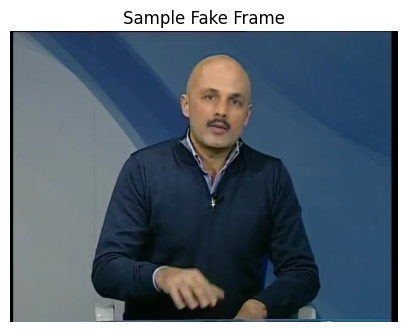

Fake face: (224, 224, 3)
Real face: (224, 224, 3)


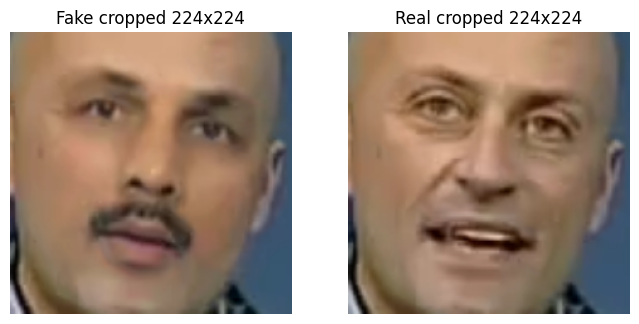

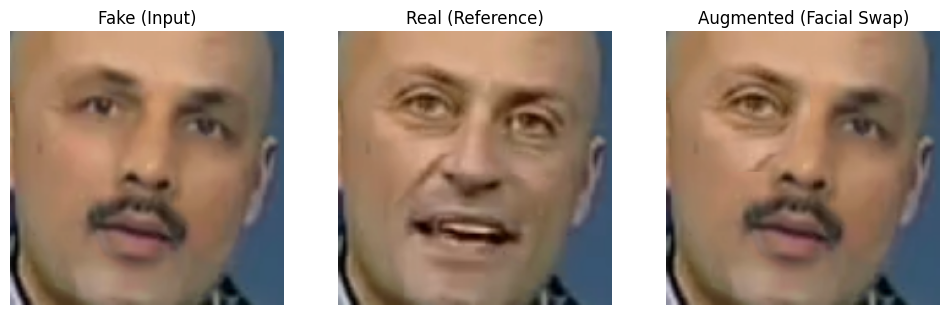

In [67]:
# === 1️⃣ مرحله استخراج فریم ===
test_fake = r"E:\firstProject\FaceForensics++\Deepfakes\003_000.mp4"
test_real = r"E:\firstProject\FaceForensics++\original\003.mp4"

fake_frames = extract_frames(test_fake, num_frames=8)
real_frames = extract_frames(test_real, num_frames=8)

print(f"Extracted {len(fake_frames)} fake frames, {len(real_frames)} real frames")

# نمایش اولین فریم فیک
plt.figure(figsize=(5,5))
plt.imshow(fake_frames[0])
plt.title("Sample Fake Frame")
plt.axis("off")
plt.show()

# === 2️⃣ مرحله تشخیص و کراپ چهره ===
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r"C:\Users\LENOVO\Desktop\third project\shape_predictor_81_face_landmarks.dat")


fake_face, fake_landmarks = detect_and_crop_face(fake_frames[0], detector, predictor)
real_face, real_landmarks = detect_and_crop_face(real_frames[0], detector, predictor)

print("Fake face:", None if fake_face is None else fake_face.shape)
print("Real face:", None if real_face is None else real_face.shape)

if fake_face is None or real_face is None:
    print("❌ Face detection failed. Try another video.")
else:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(fake_face)
    plt.title("Fake cropped 224x224")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(real_face)
    plt.title("Real cropped 224x224")
    plt.axis("off")
    plt.show()


    # === 3️⃣ مرحله تست augmentation ===
    aug = facial_swap_augmentation(fake_face, real_face, fake_landmarks)
    # === 4️⃣ نمایش نتیجه نهایی ===
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(fake_face)
    axs[0].set_title("Fake (Input)")
    axs[1].imshow(real_face)
    axs[1].set_title("Real (Reference)")
    axs[2].imshow(aug)
    axs[2].set_title("Augmented (Facial Swap)")
    for ax in axs: ax.axis("off")
    plt.show()


In [47]:
def extract_frames(video_path, num_frames=32):
    """Extract evenly spaced frames from a video."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        frame_indices = np.linspace(0, total_frames-1, total_frames, dtype=int)
    else:
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
        
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames


def detect_and_crop_face(frame, detector, predictor, target_size=(224, 224)):
    """Detect face using Dlib and crop + resize to 224x224."""
    dets = detector(frame, 1)
    if len(dets) == 0:
        return None, None
    
    areas = [(d.right() - d.left()) * (d.bottom() - d.top()) for d in dets]
    largest_idx = np.argmax(areas)
    rect = dets[largest_idx]
    shape = predictor(frame, rect)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    x1, y1 = max(rect.left(), 0), max(rect.top(), 0)
    x2, y2 = rect.right(), rect.bottom()
    face = frame[y1:y2, x1:x2]
    landmarks_rescaled = resize_landmarks(landmarks, (y2 - y1, x2 - x1))
    face = cv2.resize(face, target_size)
    return face, landmarks_rescaled

def resize_landmarks(landmarks, old_shape, new_shape=(224, 224)):
    """Rescale landmark coordinates to match resized face."""
    h_old, w_old = old_shape[:2]
    h_new, w_new = new_shape
    scale_x = w_new / w_old
    scale_y = h_new / h_old
    landmarks_rescaled = landmarks.copy().astype(np.float32)
    landmarks_rescaled[:, 0] *= scale_x
    landmarks_rescaled[:, 1] *= scale_y
    return landmarks_rescaled

import cv2
import numpy as np
import random
from skimage.metrics import structural_similarity as ssim

def align_face_by_landmarks(img, landmarks, output_size=(224, 224)):
    """
    ساده‌ترین هم‌ترازسازی با استفاده از چشم‌ها و دهان
    """
    if landmarks is None or len(landmarks) < 68:
        return cv2.resize(img, output_size)

    # نقاط کلیدی (چشم‌ها و دهان)
    left_eye = np.mean(landmarks[36:42], axis=0)
    right_eye = np.mean(landmarks[42:48], axis=0)
    mouth = np.mean(landmarks[48:68], axis=0)

    # زاویه چرخش صورت
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX))

    # مرکز چشم‌ها
    eyes_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)

    # ماتریس چرخش
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_CUBIC)

    return cv2.resize(aligned, output_size)

def facial_swap_augmentation(
    fake_face, real_face, landmarks=None,
    scales=[[40,80],[80,120],[120,160],[224,224]],
    n_patches=3, blend_strength=21, ssim_thresh=0.7, debug=False
):
    """
    نسخه پایدار multi-scale facial swap (D²Fusion / CADDM)
    """

    fake = cv2.resize(fake_face.astype(np.uint8), (224, 224))
    real = cv2.resize(real_face.astype(np.uint8), (224, 224))

    # 🔹 هم‌ترازسازی بر اساس landmarks (در صورت وجود)
    if landmarks is not None:
        fake = align_face_by_landmarks(fake, landmarks)
        real = align_face_by_landmarks(real, landmarks)

    H, W, _ = fake.shape
    augmented = fake.copy()

    # 🔹 محاسبه DSSIM map
    try:
        gray_real = cv2.cvtColor(real, cv2.COLOR_RGB2GRAY)
        gray_fake = cv2.cvtColor(fake, cv2.COLOR_RGB2GRAY)
        ssim_map = ssim(gray_real, gray_fake, full=True)[1]
        dssim_map = cv2.normalize(1 - ssim_map, None, 0, 1, cv2.NORM_MINMAX)
        ys, xs = np.where(dssim_map > ssim_thresh)
        use_dssim = len(xs) > 0
    except Exception as e:
        print("⚠️ DSSIM computation failed:", e)
        use_dssim = False

    # 🔹 fallback mask در صورت DSSIM ضعیف
    if not use_dssim:
        ys, xs = np.where(np.ones((H, W), np.uint8))
        if debug:
            print("Fallback → random patching")

    for _ in range(n_patches):
        smin, smax = random.choice(scales)
        win_size = min(random.randint(smin, smax), H, W)
        idx = np.random.randint(0, len(xs))
        cx, cy = xs[idx], ys[idx]

        x1 = np.clip(cx - win_size // 2, 0, W - win_size)
        y1 = np.clip(cy - win_size // 2, 0, H - win_size)
        x2, y2 = x1 + win_size, y1 + win_size

        # 🔹 ساخت ماسک نرم برای blending
        mask = np.zeros((win_size, win_size), dtype=np.float32)
        cv2.circle(mask, (win_size // 2, win_size // 2), win_size // 2, 1, -1)
        mask = cv2.GaussianBlur(mask, (blend_strength, blend_strength), 0)[..., np.newaxis]

        fake_patch = augmented[y1:y2, x1:x2, :]
        real_patch = real[y1:y2, x1:x2, :]

        blended = (mask * real_patch + (1 - mask) * fake_patch).astype(np.uint8)
        augmented[y1:y2, x1:x2, :] = blended

    if debug:
        print(f"Applied {n_patches} swaps → final DSSIM {use_dssim}")

    return augmented




In [89]:
class FFPlusDataset(Dataset):
    def __init__(self, csv_path, root_dir, num_frames=32, training=True,
                 transform=None, augment_prob=0.4):
        """
        Args:
            csv_path (str): مسیر CSV حاوی مسیر فایل‌ها و لیبل‌ها
            root_dir (str): مسیر پوشه FaceForensics++
            num_frames (int): تعداد فریم‌های استخراجی از هر ویدیو
            training (bool): در حالت Train یا Val
            transform: اعمال ترنسفورمیشن‌های تصویری
            augment_prob (float): احتمال اعمال Augmentation روی ویدیوهای فیک
        """
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.training = training
        self.transform = transform
        self.augment_prob = augment_prob

        # 🔹 Dlib face detector & landmark predictor
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(
            r"C:/Users/LENOVO/Desktop/third project/shape_predictor_81_face_landmarks.dat"
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = os.path.join(self.root_dir, row['File Path'])
        label = int(row['binary_Label'])  # 0 = REAL, 1 = FAKE

        # 🔹 Extract frames
        frames = extract_frames(video_path, self.num_frames)
        faces = []

        for frame in frames:
            face, landmarks = detect_and_crop_face(frame, self.detector, self.predictor)
            if face is None:
                continue

            # ✅ Apply augmentation only during training and only for fake videos
            if self.training and label == 1 and random.random() < self.augment_prob:
                try:
                    # 🧩 Find corresponding real video path
                    real_id = os.path.basename(video_path).split("_")[0] + ".mp4"
                    real_video_path = video_path.replace(os.path.basename(video_path), real_id)
                    real_video_path = (real_video_path
                                       .replace("Deepfakes", "original")
                                       .replace("Face2Face", "original")
                                       .replace("FaceSwap", "original")
                                       .replace("NeuralTextures", "original"))

                    if os.path.exists(real_video_path):
                        real_frames = extract_frames(real_video_path, self.num_frames)
                        real_face, real_lm = detect_and_crop_face(real_frames[0], self.detector, self.predictor)

                        if real_face is not None:
                            # 🔹 DSSIM-based multi-scale swap
                            face = facial_swap_augmentation(
                                fake_face=face,
                                real_face=real_face,
                                landmarks=landmarks,
                                debug=False  # optional guidance
                            )
                except Exception as e:
                    print(f"⚠️ Augmentation skipped for {video_path}: {e}")

            faces.append(face)

        # اگر هیچ فریمی چهره نداشت، خطا نده
        if len(faces) == 0:
            raise ValueError(f"No faces found in video: {video_path}")

        # 🔹 Stack frames [T,H,W,C] → [T,C,H,W]
        faces = np.stack(faces)
        faces = torch.tensor(faces).permute(0, 3, 1, 2).float() / 255.0

        if self.transform:
            faces = self.transform(faces)

        return faces, torch.tensor(label).long()

In [90]:
from torchvision import transforms

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


In [91]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=42, stratify=final_df['binary_Label'])
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7351656].


✅ Sample 0 loaded | Label = 1 | Shape = torch.Size([4, 3, 224, 224])


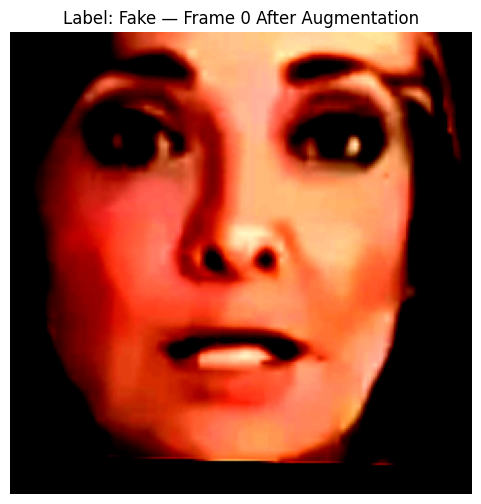

In [92]:
import matplotlib.pyplot as plt
import torch

# مسیرها را تنظیم کن
csv_path = "train_split.csv"   # یا هر CSV که داری
root_dir = r"E:\firstProject\FaceForensics++"

# ایجاد دیتاست فقط برای تست
    
test_dataset = FFPlusDataset(csv_path, root_dir, num_frames=4, training=True, augment_prob=1.0,transform=train_transform)

# انتخاب فقط یکی از آیتم‌ها
sample_idx = 0
faces, label = test_dataset[sample_idx]

print(f"✅ Sample {sample_idx} loaded | Label = {label.item()} | Shape = {faces.shape}")

# نمایش یک فریم قبل و بعد از augmentation
# چهره‌ها [T,C,H,W] → [H,W,C]
frame = faces[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(6,6))
plt.imshow(frame)
plt.title(f"Label: {'Fake' if label.item()==1 else 'Real'} — Frame 0 After Augmentation")
plt.axis('off')
plt.show()


In [82]:
train_dataset = FFPlusDataset(
    csv_path="train_split.csv",
    root_dir="E:/firstProject/FaceForensics++/",
    num_frames=32,
    training=True,
    transform=train_transform
)

val_dataset = FFPlusDataset(
    csv_path="val_split.csv",
    root_dir="E:/firstProject/FaceForensics++/",
    num_frames=32,
    training=False,
    transform=val_transform
)

In [93]:
# ایجاد DataLoader با تعادل بین کلاس‌ها
def make_balanced_loader(csv_path, root_dir, batch_size=64, training=True, transform=None):
    df = pd.read_csv(csv_path)
    dataset = FFPlusDataset(csv_path, root_dir, training=training, transform=transform)

    labels = df['binary_Label'].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weights = 1. / class_sample_count
    samples_weight = np.array([weights[t] for t in labels])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
    return loader

# مثال ساخت train/val loader
train_loader = make_balanced_loader(
    csv_path="train_split.csv",
    root_dir="E:/firstProject/FaceForensics++/",
    batch_size=64,
    training=True
)

val_loader = make_balanced_loader(
    csv_path="val_split.csv",
    root_dir="E:/firstProject/FaceForensics++/",
    batch_size=64,
    training=False
)

In [96]:
class ResNet34FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True, temporal_agg="mean"):
        super().__init__()
        resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = nn.Sequential(
            resnet34.conv1,
            resnet34.bn1,
            resnet34.relu,
            resnet34.maxpool,
            resnet34.layer1,
            resnet34.layer2,
            resnet34.layer3,
            resnet34.layer4
        )
        self.temporal_agg = temporal_agg  # "mean" | "max"

    def forward(self, x):
        """
        x: [B, T, C, H, W]
        output: [B, 512, 7, 7]
        """
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.features(x)
        feats = feats.view(B, T, 512, 7, 7)

        if self.temporal_agg == "mean":
            feats = feats.mean(dim=1)
        elif self.temporal_agg == "max":
            feats, _ = feats.max(dim=1)
        else:
            raise ValueError("Invalid temporal aggregation mode")

        return feats

In [97]:
x = torch.randn(2, 8, 3, 224, 224)  # 2 ویدیو، هرکدام 8 فریم
model = ResNet34FeatureExtractor(pretrained=False)
out = model(x)
print(out.shape)


torch.Size([2, 512, 7, 7])


In [2]:
class BiDirectionalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv_h = nn.Conv2d(channels, channels, kernel_size=1, bias=True)  
        self.conv_w = nn.Conv2d(channels, channels, kernel_size=1, bias=True)  
        self.sigmoid = nn.Sigmoid()

    def forward(self,X):
      B,C,H,W = X.shape
      ZH = X.mean(dim=3, keepdim=True)  # (B, C, H, 1)
      YW = X.mean(dim=2, keepdim=True)
      qn = torch.cat([ZH, YW.permute(0,1,3,2)], dim=2)

      fc = self.conv1(qn)
      fc = self.bn1(fc)
      fc = self.relu(fc)

      fh = fc[:, :, :H, :]
      fw = fc[:, :, H:, :]
      fw = fw.permute(0,1,3,2)

      Ah = self.sigmoid(self.conv_h(fh))    # (B, C, H, 1)
      Aw = self.sigmoid(self.conv_w(fw))    # (B, C, 1, W)

      X_bi = X * Ah * Aw                # (B, C, H, W)

      return X_bi

In [3]:
import torch
import torch.nn as nn
from torch_dct import dct_2d

class FineGrainedSpectralAttention(nn.Module):
    """
    Implements Section 3.3.2 using torch_dct.dct_2d for frequency domain transformation.
    Input: X of shape (B, C, H, W)
    Output: X_sp of shape (B, C, H, W)
    """
    def __init__(self, channels, n_groups=4, hidden_ratio=0.25):
        super().__init__()
        assert channels % n_groups == 0, "Channels must be divisible by n_groups"
        self.C = channels
        self.n = n_groups
        self.group_c = channels // n_groups

        # MLP to generate channel-wise attention weights
        hidden = max(8, int(channels * hidden_ratio))
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels),
            nn.Sigmoid()
        )

    def forward(self, X):
        B, C, H, W = X.shape
        # Split channels into n groups
        groups = X.view(B, self.n, self.group_c, H, W)  # (B, n, Gc, H, W)

        summaries = []
        for gi in range(self.n):
            Xi = groups[:, gi]              # (B, Gc, H, W)
            X_dct = dct_2d(Xi)              # DCT-II transform

            # Focus on high-frequency components: bottom-right quadrant
            hf_mask = torch.zeros(H, W, device=X.device)
            hf_mask[int(H*0.5):, int(W*0.5):] = 1.0
            hf_mask = hf_mask.view(1, 1, H, W)  # broadcastable

            # Weighted average of DCT magnitude in high-frequency region
            hf_energy = (X_dct * hf_mask).mean(dim=(2, 3))  # (B, Gc)
            summaries.append(hf_energy)

        # Concatenate all group summaries → (B, C)
        S = torch.cat(summaries, dim=1)

        # MLP → channel-wise attention weights
        weights = self.fc(S).view(B, C, 1, 1)  # (B, C, 1, 1)
        X_sp = X * weights                    # (B, C, H, W)
        return X_sp

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def has_torch_dct():
    return hasattr(torch.fft, "dct")

class BiDirectionalAttention(nn.Module):
    """
    Bi-directional attention as in Section 3.3.1.
    Input: X of shape (B, C, H, W)
    Output: X_bi of shape (B, C, H, W)
    """
    def __init__(self, channels):
        super().__init__()
        # 1x1 conv to enhance concatenated strip features
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(channels)
        self.act = nn.ReLU(inplace=True)
        # Direction-specific projections
        self.Fh = nn.Conv2d(channels, channels, kernel_size=1, bias=True)  # for C×H×1
        self.Fw = nn.Conv2d(channels, channels, kernel_size=1, bias=True)  # for C×1×W
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        B, C, H, W = X.shape

        # Horizontal strip pooling: mean over width -> (B, C, H, 1)
        ZH = X.mean(dim=3, keepdim=True)  # (B, C, H, 1)

        # Vertical strip pooling: mean over height -> (B, C, 1, W)
        YW = X.mean(dim=2, keepdim=True)  # (B, C, 1, W)

        # Concatenate along "strip length": we map both to (B, C, H+W, 1)
        # and stack by constructing a tensor that places YW in the H..H+W range
        # Easiest: pad along height to H+W and add YW (aligned across width dimension)
        qn = torch.cat([ZH, YW.permute(0,1,3,2)], dim=2)  # (B, C, H + W, 1)

        # Enhance with 1x1 conv + BN + ReLU
        fc = self.conv1(qn)               # (B, C, H+W, 1)
        fc = self.bn1(fc)
        fc = self.act(fc)

        # Split back into directional tensors
        fh = fc[:, :, :H, :]              # (B, C, H, 1)
        fw = fc[:, :, H:, :]              # (B, C, W, 1)
        fw = fw.permute(0, 1, 3, 2)       # (B, C, 1, W)

        # Directional 1x1 projections + sigmoid
        Ah = self.sigmoid(self.Fh(fh))    # (B, C, H, 1)
        Aw = self.sigmoid(self.Fw(fw))    # (B, C, 1, W)

        # Broadcast and reweight
        X_bi = X * Ah * Aw                # (B, C, H, W)
        return X_bi


class FineGrainedSpectralAttention(nn.Module):
    """
    Fine-grained spectral attention as in Section 3.3.2.
    - Split channels into n groups
    - Transform each group to frequency domain (DCT if available; else FFT2)
    - Summarize frequencies and produce group/channel weights via small MLP
    Input: X of shape (B, C, H, W)
    Output: X_sp of shape (B, C, H, W)
    """
    def __init__(self, channels, n_groups=4, summary_mode="highfreq", use_dct=None, hidden_ratio=0.25):
        super().__init__()
        assert channels % n_groups == 0, "C must be divisible by n_groups"
        self.C = channels
        self.n = n_groups
        self.group_c = channels // n_groups
        self.summary_mode = summary_mode
        self.use_dct = has_torch_dct() if use_dct is None else use_dct

        # MLP over concatenated group summaries -> per-channel weights
        hidden = max(8, int(channels * hidden_ratio))
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels),
            nn.Sigmoid()
        )

    def _dct2(self, x):
        # x: (B, Gc, H, W)
        # DCT-II along H then W, if available; else FFT fallback
        if self.use_dct:
            # Normalize='ortho' gives DCT-II orthonormal transform
            x = torch.fft.dct(x, type=2, dim=-2, norm='ortho')
            x = torch.fft.dct(x, type=2, dim=-1, norm='ortho')
            return x
        else:
            # FFT2 magnitude as a robust approximation to frequency energy
            Xf = torch.fft.fft2(x, norm='ortho')
            return torch.abs(Xf)

    def _summarize_group(self, Xf):
        # Xf: (B, Gc, H, W) frequency-domain representation
        B, Gc, H, W = Xf.shape
        if self.summary_mode == "highfreq":
            # emphasize high frequencies (bottom-right quadrant)
            h_mask = torch.zeros(H, device=Xf.device)
            w_mask = torch.zeros(W, device=Xf.device)
            h_mask[int(H*0.5):] = 1.0
            w_mask[int(W*0.5):] = 1.0
            mask = torch.ger(h_mask, w_mask)  # (H,W)
            mask = mask.view(1, 1, H, W)
            # average masked magnitude per channel
            num = (Xf * mask).sum(dim=(2,3)) + 1e-6
            denom = mask.sum() + 1e-6
            return (num / denom)  # (B, Gc)
        elif self.summary_mode == "global":
            return Xf.mean(dim=(2,3))  # (B, Gc)
        else:
            # Custom banding could be implemented here
            return Xf.mean(dim=(2,3))

    def forward(self, X):
        B, C, H, W = X.shape
        groups = X.view(B, self.n, self.group_c, H, W)  # (B, n, Gc, H, W)

        summaries = []
        for gi in range(self.n):
            Xi = groups[:, gi]                # (B, Gc, H, W)
            Xfi = self._dct2(Xi)              # (B, Gc, H, W) in frequency domain
            si = self._summarize_group(Xfi)   # (B, Gc)
            summaries.append(si)

        # Concatenate all group summaries -> (B, C)
        S = torch.cat(summaries, dim=1)

        # MLP -> per-channel weights (B, C), then broadcast
        w = self.fc(S).view(B, C, 1, 1)
        X_sp = X * w
        return X_sp


class DualDomainAttentionBlock(nn.Module):
    """
    Combines BiDirectionalAttention and FineGrainedSpectralAttention.
    """
    def __init__(self, channels, n_groups=4, summary_mode="highfreq", use_dct=None, merge="sum"):
        super().__init__()
        self.spatial = BiDirectionalAttention(channels)
        self.freq = FineGrainedSpectralAttention(channels, n_groups, summary_mode, use_dct)
        assert merge in ("sum", "concat")
        self.merge = merge
        if merge == "concat":
            self.out_proj = nn.Conv2d(channels*2, channels, kernel_size=1)

    def forward(self, X):
        X_bi = self.spatial(X)
        X_sp = self.freq(X)
        if self.merge == "sum":
            return X_bi + X_sp
        else:
            Z = torch.cat([X_bi, X_sp], dim=1)
            return self.out_proj(Z)


# Example integration with a backbone block
class SpatialDomainBranch(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups=4):
        super().__init__()
        # Example: a simple conv block followed by dual-domain attention
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.dual = DualDomainAttentionBlock(out_channels, n_groups=n_groups, summary_mode="highfreq", merge="sum")

    def forward(self, x):
        x = self.conv(x)
        x = self.dual(x)
        return x


class FrequencyDomainBranch(nn.Module):
    def __init__(self, channels, n_groups=4):
        super().__init__()
        # Frequency only attention branch (if you want it standalone)
        self.freq = FineGrainedSpectralAttention(channels, n_groups=4)

    def forward(self, x):
        return self.freq(x)


# Quick sanity check
if __name__ == "__main__":
    B, C, H, W = 2, 64, 28, 28
    x = torch.randn(B, C, H, W)

    bi = BiDirectionalAttention(C)
    y_bi = bi(x)
    print("Bi-directional out:", y_bi.shape)

    sp = FineGrainedSpectralAttention(C, n_groups=4)
    y_sp = sp(x)
    print("Spectral out:", y_sp.shape)

    dual = DualDomainAttentionBlock(C, n_groups=4, merge="sum")
    y_dual = dual(x)
    print("Dual out:", y_dual.shape)

Bi-directional out: torch.Size([2, 64, 28, 28])
Spectral out: torch.Size([2, 64, 28, 28])
Dual out: torch.Size([2, 64, 28, 28])
